Draw the different graphs with neurons of particular interest, such as MDNs, 
the hub interneurons, and experimentally identified neurons.

In [94]:
import os

import matplotlib.pyplot as plt
import pandas as pd

from vnc_networks import MANC, params
from vnc_networks.specific_neurons import mdn_helper
from vnc_networks.utils import nx_design


In [95]:
# ----- Directories
manc_version = "v1.2"
MDN_DIR = "MDN_project"
FIG_DIR = MANC(manc_version).get_fig_dir()
MDN_FIGS = os.path.join(FIG_DIR, MDN_DIR)
LOCAL_DIR = os.path.join(MDN_FIGS, "graphs")
os.makedirs(MDN_FIGS, exist_ok=True)
os.makedirs(LOCAL_DIR, exist_ok=True)

# Analysis choices
side = "RHS"
leg = "h"
# Syanpse threshold for visualisation
SYNAPSE_THRESHOLD = 40

# Save?
savefigs = True

# Get the relevant neurons

In [96]:
CR = MANC(manc_version)
# Get the graph with MDNs split by neuropil
split_mdn_vnc = mdn_helper.get_vnc_split_MDNs_by_neuropil(
    not_connected=mdn_helper.get_mdn_bodyids()
)
_ = split_mdn_vnc.get_node_attribute([], "type")

Loaded VNC Connections object with MDNs split by neuropil.
Attribute type not found in the graph. Adding it.


In [97]:
# Get MDNs
mdn_uids = mdn_helper.get_subdivided_mdns(
    split_mdn_vnc,
    neuropil=leg,
)

In [98]:
# Experimental neurons: LBL40
lbl40 = split_mdn_vnc.get_neuron_ids({"type": "LBL40"})
lbl40_df = split_mdn_vnc.list_neuron_properties(lbl40)

In [99]:
# Experimental neurons: LUL130
lul130 = split_mdn_vnc.get_neuron_ids({"type": "INXXX468"})
lul130_df = split_mdn_vnc.list_neuron_properties(lul130)

In [100]:
# Get the key premotor neurons
premotor_df = pd.read_csv(
    os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_MDN_premotor_hubs.csv"),
)
pmn_bodyids = premotor_df["body_id"].values
pmn_uids = split_mdn_vnc.get_uids_from_bodyids(pmn_bodyids)


In [101]:
# Get the right leg motor neurons
mn_df = pd.read_csv(
    os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_MDN_input.csv"),
)
mn_df = mn_df[["uid", "cluster"]]
mn_uids = mn_df["uid"].values
mn_df

,uid,cluster
0,53,0
1,239,0
2,735,0
3,1225,0
4,1528,0
...,...,...
57,23268,4
58,10621,5
59,14068,5
60,20533,5


In [102]:
# Subset the graph to the relevant nodes
highlighted_nodes = list(set(mdn_uids) | set(lbl40) | set(lul130) | set(pmn_uids) | set(mn_uids))
subnetwork = split_mdn_vnc.subgraph(
    highlighted_nodes,
)

Attribute class_1 not found in the graph. Adding it.


In [103]:
# Merge experimental neurons into a single node
subnetwork.merge_nodes(lbl40)
subnetwork.merge_nodes(lul130)
# Merge MDNs into a single node
subnetwork.merge_nodes(mdn_uids)
# Merge motor neurons into a single node per cluster
for cluster in mn_df["cluster"].unique():
    cluster_uids = mn_df[mn_df["cluster"] == cluster]["uid"].values
    subnetwork.merge_nodes(cluster_uids, combination_logic="sum")
    subnetwork.graph.nodes[cluster_uids[0]]["node_label"] = f"cluster_{cluster + 1}" # zero-indexed

In [104]:
_ = subnetwork.get_node_attribute([], "nt_type")
_ = subnetwork.get_node_attribute([], "type")
all_nodes = subnetwork.get_nodes()
df = subnetwork.list_neuron_properties(all_nodes)
df

Attribute nt_type not found in the graph. Adding it.
Attribute type not found in the graph. Adding it.


,body_id,node_label,class_1,node_class,nt_type,type,uid
7024,10372,IN19A003,intrinsic,intrinsic,gaba,IN19A003,7024
15581,10425,IN13B006,intrinsic,intrinsic,gaba,IN13B006,15581
21924,10513,INXXX053,intrinsic,intrinsic,gaba,INXXX053,21924
11907,11325,IN21A010,intrinsic,intrinsic,acetylcholine,IN21A010,11907
9431,11819,IN08A006,intrinsic,intrinsic,gaba,IN08A006,9431
1740,20667,cluster_4,motor,motor,glutamate,Sternal adductor MN,1740
644,22465,cluster_3,motor,motor,glutamate,Tr flexor MN,644
9595,10380,IN09A002,intrinsic,intrinsic,gaba,IN09A002,9595
3881,10968,cluster_5,motor,motor,glutamate,MNhl68,3881
621,13069,cluster_2,motor,motor,glutamate,Sternotrochanter MN,621


In [105]:
interneuron_ids = [
    9595,
    21924,
    7024,
    15581,
    19455,
    11907,
    9431,
]
mn_ids = [53, 3881, 644, 621, 1740, 10621]
mdn_id = [4523]
lbl40_id = [17753]
lul130_id = [3178]

## Figure 0: connections to motor neuron clusters

In [106]:
interneurons_and_mns = interneuron_ids + mn_ids
subgraph_0 = subnetwork.subgraph(nodes=interneurons_and_mns)

pos0 = {
    9595: (0, 0),
    21924: (1, 0),
    19455: (2, 0),
    11907: (2.1, 0),
    15581: (3, 0),
    7024: (4, 0),
    9431: (5, 0),
    53: (0, -1),
    3881: (1, -1),
    644: (2, -1),
    621: (3, -1),
    1740: (4, -1),
    10621: (5, -1),
}

Attribute class_1 not found in the graph. Adding it.


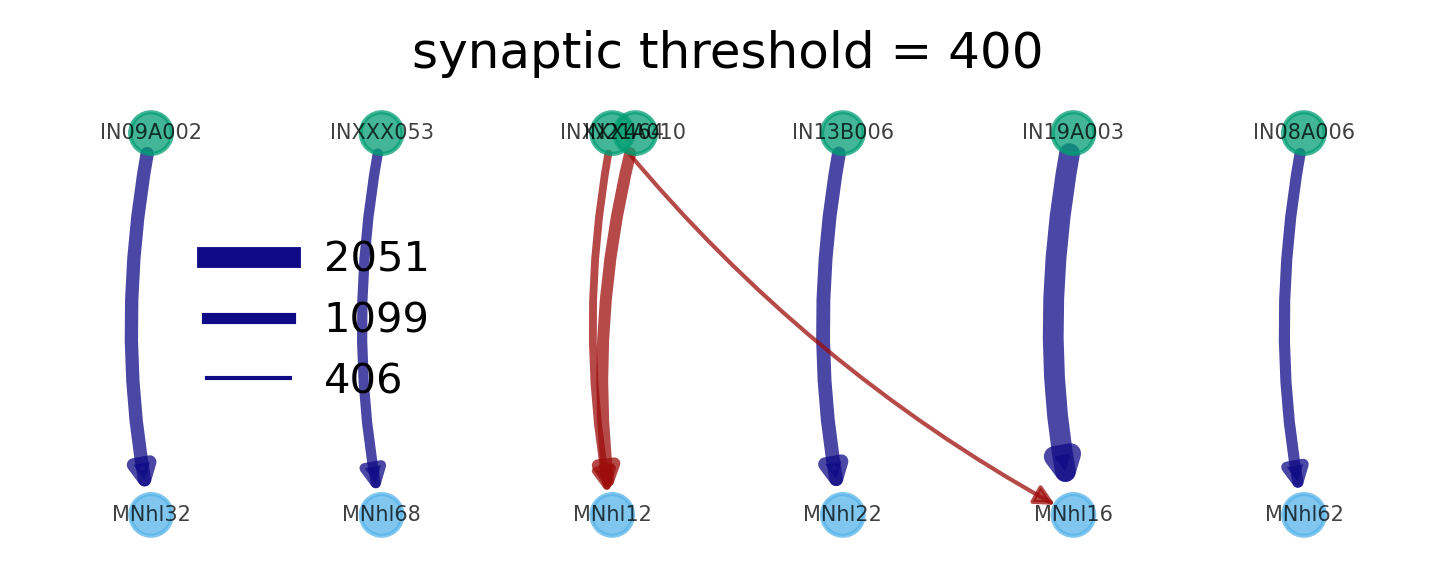

In [107]:
avg_nb_mns_per_cluster = len(mn_uids) // len(mn_df["cluster"].unique())
syn_thresh = SYNAPSE_THRESHOLD * avg_nb_mns_per_cluster

fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=params.DPI)
subgraph_0.display_graph(
    pos=pos0,
    label_nodes=True,
    save=False,
    ax=ax,
    syn_threshold=syn_thresh,
    title=f"synaptic threshold = {syn_thresh}",
)

if savefigs:
    plt.savefig(
        os.path.join(LOCAL_DIR, "special_premotor_mns_graph_line.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()


In [108]:
graph_0 = subgraph_0.graph
# remove all the edges that are below the syn_thresh
edges_to_keep_inter_mn = []
for edge in graph_0.edges:
    weight = graph_0.edges[edge]["weight"]
    if abs(weight) >= syn_thresh:
        edges_to_keep_inter_mn.append((edge[0], edge[1], weight))

## Figure 1: How the interneurons are organized

In [109]:
interneurons_and_mdn = interneuron_ids + mdn_id
subgraph_1 = subnetwork.subgraph(nodes=interneurons_and_mdn)

pos1 = {
    9595: (0, 0),
    21924: (1, 0),
    7024: (2, 0),
    15581: (0, 1),
    19455: (1, 1.1),
    11907: (1, 0.9),
    9431: (2, 1),
    4523: (1, 1.5),
}

Attribute class_1 not found in the graph. Adding it.


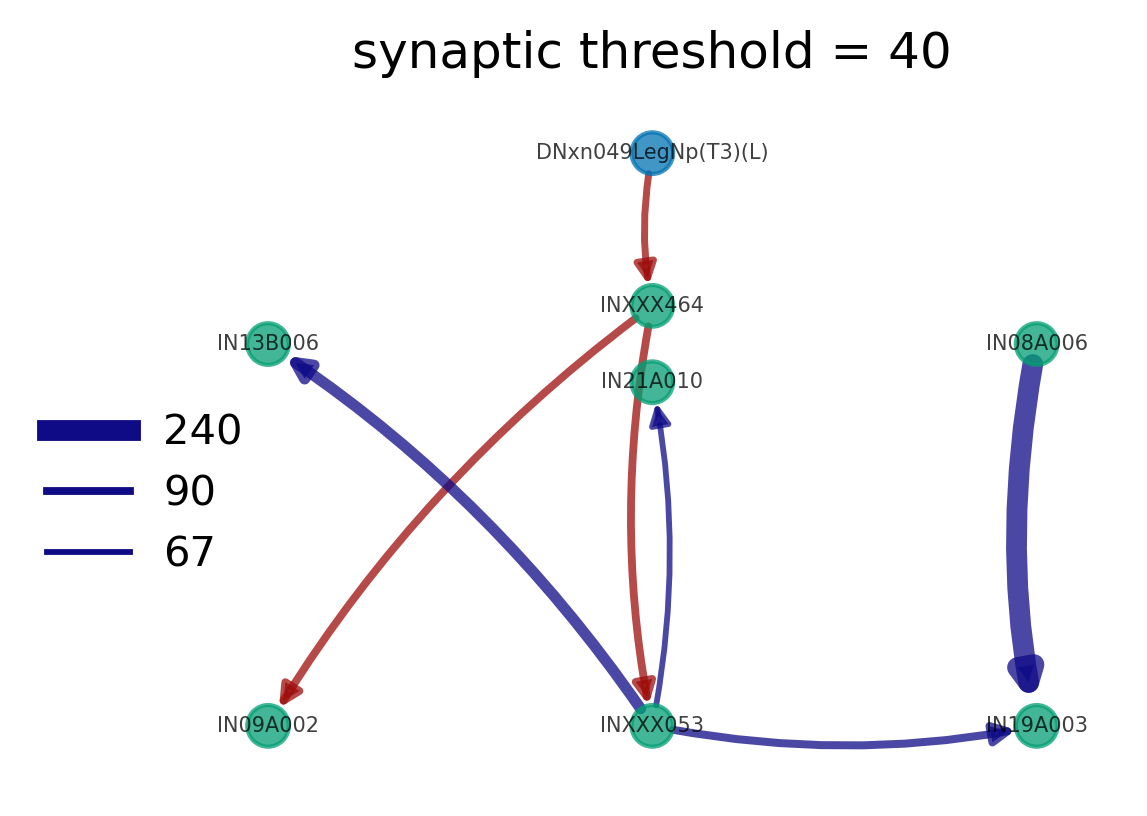

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=params.DPI)
subgraph_1.display_graph(
    pos=pos1,
    label_nodes=True,
    save=False,
    ax=ax,
    syn_threshold=SYNAPSE_THRESHOLD,
    title=f"synaptic threshold = {SYNAPSE_THRESHOLD}",
)

if savefigs:
    plt.savefig(
        os.path.join(LOCAL_DIR, "special_premotor_graph_circle.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()

## Figure 2: How experimental neurons contact the interneurons

In [111]:
interneurons_and_exp = interneuron_ids + lbl40_id + lul130_id
subgraph_2 = subnetwork.subgraph(nodes=interneurons_and_exp)


Attribute class_1 not found in the graph. Adding it.


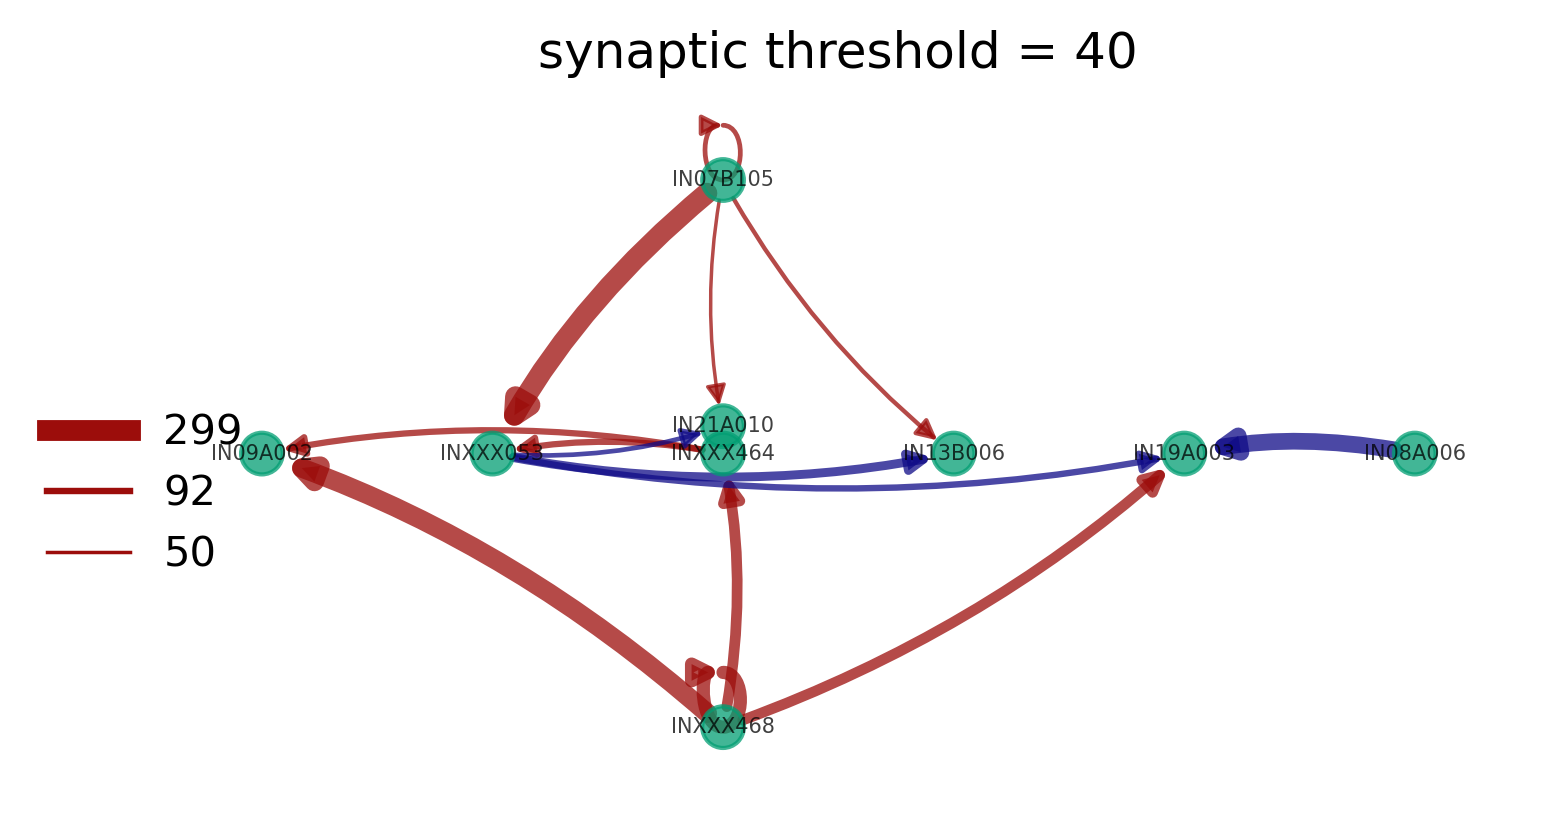

In [112]:
pos2 = {
    9595: (0, 0),
    21924: (1, 0),
    19455: (2, 0),
    11907: (2, 0.1),
    15581: (3, 0),
    7024: (4, 0),
    9431: (5, 0),
    17753: (2, 1),
    3178: (2, -1),
}

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=params.DPI)
subgraph_2.display_graph(
    pos=pos2,
    label_nodes=True,
    save=False,
    ax=ax,
    syn_threshold=SYNAPSE_THRESHOLD,
    title=f"synaptic threshold = {SYNAPSE_THRESHOLD}",
)

if savefigs:
    plt.savefig(
        os.path.join(LOCAL_DIR, "special_premotor_lbl40_lul130_graph_line.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()


## Figure 3: How the experimental neurons contact the motor neurons as well

In [113]:
exp_inter_mn = lbl40_id + lul130_id + mn_ids + interneuron_ids
subgraph_3 = subnetwork.subgraph(nodes=exp_inter_mn)

Attribute class_1 not found in the graph. Adding it.


In [114]:
graph3 = subgraph_3.graph
# remove edges between interneurons and motor neurons for visibility
for n1 in interneuron_ids:
    for n2 in mn_ids:
        if graph3.has_edge(n1, n2):
            graph3.remove_edge(n1, n2)
        if graph3.has_edge(n2, n1):
            graph3.remove_edge(n2, n1)
        for n3 in mn_ids: # remove edges between motor neurons
            if graph3.has_edge(n2, n3):
                graph3.remove_edge(n2, n3)
    for n4 in interneuron_ids:
        if graph3.has_edge(n1, n4):
            graph3.remove_edge(n1, n4)

# remove edges with weights below the threshold
edges_to_remove = []
for n1, n2, data in graph3.edges(data=True):
    if abs(data["weight"]) < SYNAPSE_THRESHOLD:
        edges_to_remove.append((n1, n2))
for n1, n2 in edges_to_remove:
    graph3.remove_edge(n1, n2)

# Remove self loops in the experimental neurons
graph3.remove_edge(lbl40_id[0], lbl40_id[0])
graph3.remove_edge(lul130_id[0], lul130_id[0])

# Add the strongest edges as shown in figure 0
#for edge in edges_to_keep_inter_mn:
#    n1, n2, w = edge
#    graph3.add_edge(n1, n2, weight=w)

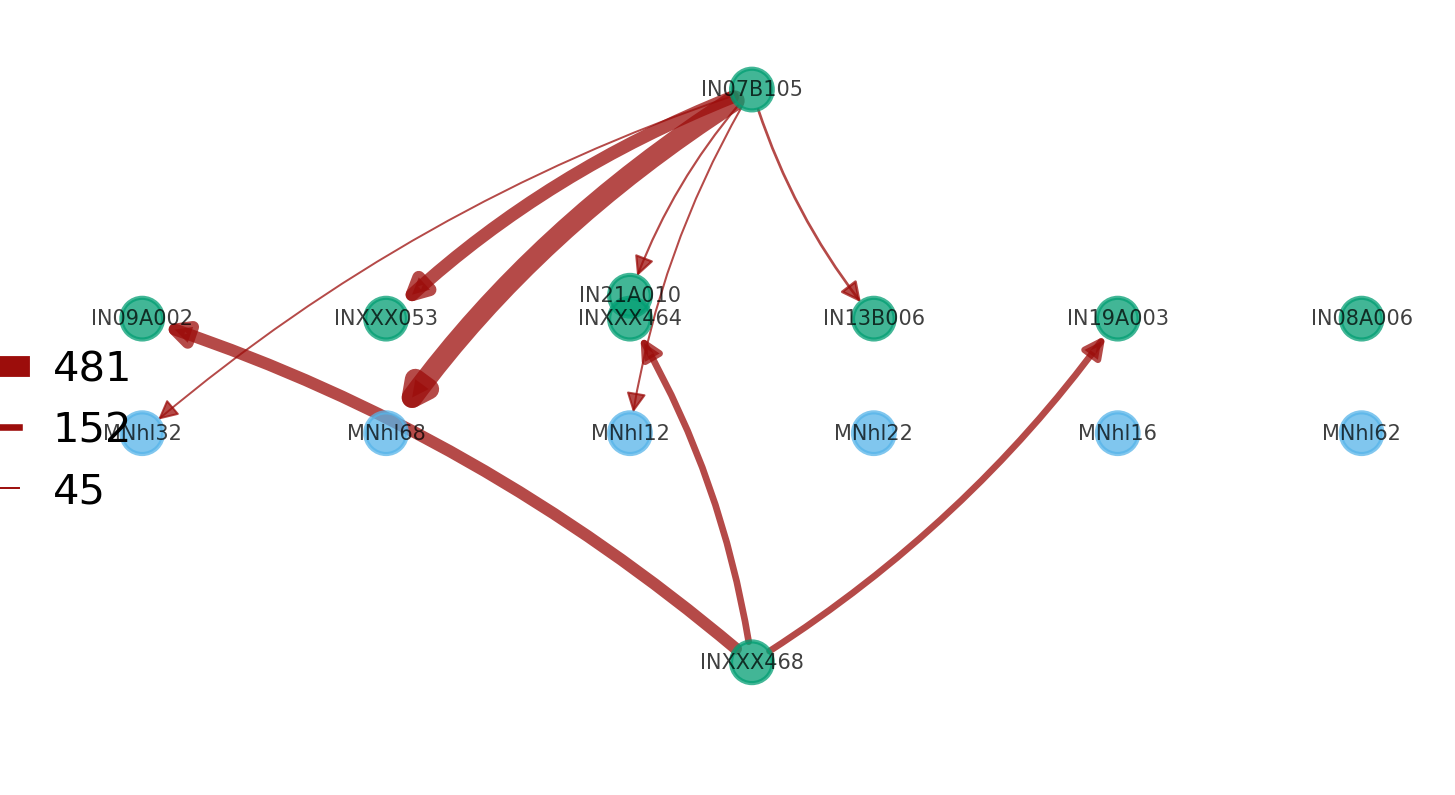

In [115]:
pos3 = {
    9595: (0, 0),
    21924: (1, 0),
    19455: (2, 0),
    11907: (2, 0.1),
    15581: (3, 0),
    7024: (4, 0),
    9431: (5, 0),
    17753: (2.5, 1),
    3178: (2.5, -1.5),
    53: (0, -0.5),
    3881: (1, -0.5),
    644: (2, -0.5),
    621: (3, -0.5),
    1740: (4, -0.5),
    10621: (5, -0.5),
}

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=params.DPI)
nx_design.draw_graph(
    graph3,
    pos=pos3,
    label_nodes=True,
    ax=ax,
)

if savefigs:
    plt.savefig(
        os.path.join(LOCAL_DIR, "special_premotor_lbl40_lul130_mns_graph_line.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()
